<a href="https://colab.research.google.com/github/jackgaul/BCI_project/blob/main/4channel_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import os
import numpy as np
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from scipy import stats
import matplotlib.pyplot as plt

In [ ]:
#load np array
#loadedData = np.load('drive/MyDrive/bci/MindBigDataVisualMnist2021-Muse2v0.17.txtstructed.npy',allow_pickle = True)
loadedData = np.load('drive/MyDrive/bci/Muse2_cleaned_cut2structednp.npy',allow_pickle = True)


In [ ]:
np.random.shuffle(loadedData)
loadedData_train = loadedData[:(int(len(loadedData)*0.8))]
loadedData_test = loadedData[(int(len(loadedData)*0.8)):]

In [ ]:
#extract labels
labelvec_train = []
labelvec_test = []
blank_count= 0
for i in loadedData_train:
  if i[3] != "-1":
    
    labelvec_train.append(int(i[3]))
    blank_count +=1

for i in loadedData_test:
  if i[3] != "-1":
    
    labelvec_test.append(int(i[3]))
    blank_count +=1
print(blank_count)

11387


In [ ]:
# Loop through the loaded file and grab all the EEG values 
# should we do the absolute value

def full4Channel(loadedData):
  examplelist = []
  index = 0
  for j in range(len(loadedData)):
    
    if loadedData[j][3] != "-1":
      examplelist.append([[[],[],[],[]]])
    #print(examplelist[0][0])
      for i in range(512):
        examplelist[index][0][0].append(abs(float(loadedData[j][4][i])))
        examplelist[index][0][1].append(abs(float(loadedData[j][4][512 + i])))
        examplelist[index][0][2].append(abs(float(loadedData[j][4][512*2 +i])))
        examplelist[index][0][3].append(abs(float(loadedData[j][4][512*3+i])))
      index +=1
  return examplelist

def twoChannel(loadedData):
  examplelist = []
  index = 0
  for j in range(len(loadedData)):
    
    if loadedData[j][3] != "-1":
      examplelist.append([[[],[]]])
    #print(examplelist[0][0])
      for i in range(512):
        examplelist[index][0][0].append(abs(float(loadedData[j][4][i])))
        examplelist[index][0][1].append(abs(float(loadedData[j][4][512 + i])))
      index +=1
  return examplelist


examplelist_train = twoChannel(loadedData_train)
examplelist_test = twoChannel(loadedData_test)



In [ ]:

catch_train = np.array(examplelist_train)
catch_test = np.array(examplelist_test)

In [ ]:
## To save RAM we can deleted the raw loaded data and the raw list 

del loadedData
del examplelist

gc.collect()

44

In [ ]:
#use z score to normalize data

def zscore4channel(catch):
  for i in range(catch.shape[0]):
    catch[i][0][0] = stats.zscore(catch[i][0][0])
    catch[i][0][1] = stats.zscore(catch[i][0][1])
    catch[i][0][2] = stats.zscore(catch[i][0][2])
    catch[i][0][3] = stats.zscore(catch[i][0][3])
    #print(catch[0][0][0])
  return catch

def zscore2channel(catch):
  for i in range(catch.shape[0]):
    catch[i][0][0] = stats.zscore(catch[i][0][0])
    catch[i][0][1] = stats.zscore(catch[i][0][1])
  
    #print(catch[0][0][0])
  return catch

catch_train = zscore2channel(catch_train)
catch_test = zscore2channel(catch_test)

In [ ]:
# custome dataset model needed to use the pytorch dataloader
class eeg_dataset(Dataset):
  def __init__(self,nparray_data,labels) -> None:
    super().__init__()
    self.dataset = torch.tensor(nparray_data, dtype=torch.float)
    self.labels = torch.tensor(np.array(labels)).long()
  def __len__(self):
    return(len(self.dataset))
  def __getitem__(self, index):
    return self.dataset[index], self.labels[index]

In [ ]:
#create the dataset object
special_dataset_train = eeg_dataset(catch_train,labelvec_train)
special_dataset_test = eeg_dataset(catch_test,labelvec_test)

In [ ]:
#Network Params

latent_dims = 256
num_epochs_auto = 80
num_epochs_class = 120
batch_size = 128
capacity = 256
learning_rate = 1e-3
channels = 2
use_gpu = True

In [ ]:
dataloader_train = DataLoader(special_dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(special_dataset_test, batch_size=batch_size, shuffle=True)


In [ ]:


#testing out 1D
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=(1,4), stride=(1,2), padding=(0,1)) # out: c x 14 x 14 ( c x 4 x 256?)
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=(1,4), stride=(1,2), padding=(0,1)) # out: c x 7 x 7 (c x 4 x 128)
        self.fc = nn.Linear(in_features=c*2*channels*128, out_features=latent_dims)# 2*7*7
        self.drop1 = nn.Dropout(0.25)
        self.drop2 = nn.Dropout(0.25)
            
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.drop1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.drop2(x)
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*channels*128)# 2*7*7
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=(1,4), stride=(1,2), padding=(0,1))
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=(1,4), stride=(1,2), padding=(0,1))
        self.drop1 = nn.Dropout(0.25)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, channels, 128) #2*7*7 unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = self.conv2(x)
        x = F.relu(x)
        x = self.drop1(x)
        x = self.conv1(x)
        x = torch.tanh(x) # last layer before output is tanh, since the images are normalized and 0-centered
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon

    def encode(self,x):
      latent = self.encoder(x)
      return latent
    
autoencoder = Autoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)
print(device)

num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

cuda:0
Number of parameters: 68291841


In [ ]:
#Train Encoder

optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
autoencoder.float()
# set to training mode
autoencoder.train()

encode_train_loss_avg = []


print('Training ...')
for epoch in range(num_epochs_auto):
    encode_train_loss_avg.append(0)
    num_batches = 0
    
    #for image_batch, h in train_dataloader:
    for image_batch, h in dataloader_train: #eeg loaded

        image_batch = image_batch.to(device)

        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)

        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        encode_train_loss_avg[-1] += loss.item()
        num_batches += 1
        

    #break

    encode_train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs_auto, encode_train_loss_avg[-1]))

Training ...
Epoch [1 / 80] average reconstruction error: 0.811002
Epoch [2 / 80] average reconstruction error: 0.675529
Epoch [3 / 80] average reconstruction error: 0.638643
Epoch [4 / 80] average reconstruction error: 0.585747
Epoch [5 / 80] average reconstruction error: 0.533453
Epoch [6 / 80] average reconstruction error: 0.501238
Epoch [7 / 80] average reconstruction error: 0.479045
Epoch [8 / 80] average reconstruction error: 0.463036
Epoch [9 / 80] average reconstruction error: 0.448534
Epoch [10 / 80] average reconstruction error: 0.433405
Epoch [11 / 80] average reconstruction error: 0.416296
Epoch [12 / 80] average reconstruction error: 0.406459
Epoch [13 / 80] average reconstruction error: 0.396866
Epoch [14 / 80] average reconstruction error: 0.387869
Epoch [15 / 80] average reconstruction error: 0.380428
Epoch [16 / 80] average reconstruction error: 0.376189
Epoch [17 / 80] average reconstruction error: 0.368481
Epoch [18 / 80] average reconstruction error: 0.361496
Epoch 

In [ ]:
#Test Encoder

# set to autoencoder to evaluation mode
autoencoder.eval()


encode_test_loss_avg = 0
num_batches = 0

print('Training ...')

for image_batch, h in dataloader_test: #eeg loaded

  with torch.no_grad():
       
    image_batch = image_batch.to(device)
            
            # autoencoder reconstruction
    image_batch_recon = autoencoder(image_batch)
            
            # reconstruction error
    loss = F.mse_loss(image_batch_recon, image_batch)
            
        
    encode_test_loss_avg += loss.item()
    num_batches += 1
        

encode_test_loss_avg /= num_batches
print('average reconstruction error: %f' % (encode_test_loss_avg))



Training ...
average reconstruction error: 0.436751


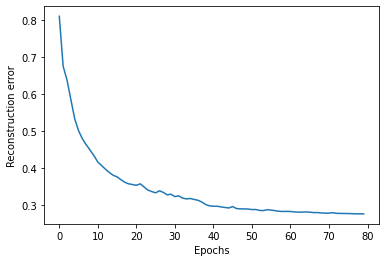

In [ ]:
# Plot Train Loss Encoder
plt.ion()

fig = plt.figure()
plt.plot(encode_train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

In [ ]:
# Save model
torch.save(autoencoder.state_dict(),'drive/MyDrive/bci/eegautoencoderfinal2channel.pt')

In [ ]:
#Load model
loaded_encoder = Autoencoder()
loaded_encoder.load_state_dict(torch.load('drive/MyDrive/bci/eegautoencoder.pt'))
loaded_encoder.eval()

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 256, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1))
    (conv2): Conv2d(256, 512, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1))
    (fc): Linear(in_features=262144, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=256, out_features=262144, bias=True)
    (conv2): ConvTranspose2d(512, 256, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1))
    (conv1): ConvTranspose2d(256, 1, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1))
  )
)

In [ ]:
#classification layer
devicecpu='cpu'
class ClassifyDigit(nn.Module):
  def __init__(self):
    super(ClassifyDigit,self).__init__()
    self.fc1 = nn.Linear(in_features=latent_dims, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=10)
    self.drop1 = nn.Dropout(0.25)

  def forward(self,x):
    x = self.fc1(x)
    x = F.relu(x)
    x = self.drop1(x)
    x = self.fc2(x)
    #x = F.relu(x)
    #x = F.log_softmax(x)
    return x


classify = ClassifyDigit()

classify = classify.to(device)
print(device)

num_params = sum(p.numel() for p in classify.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

cuda:0
Number of parameters: 34186


In [ ]:
#train classifier
optimizer = torch.optim.Adam(params=classify.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
classify.train()

train_loss_avg_class = []


print('Training ...')
for epoch in range(num_epochs_class):
    train_loss_avg_class.append(0)
    num_batches = 0
    
    #for image_batch, h in train_dataloader:
    for image_batch, target in dataloader_train: #eeg loaded
        
        image_batch = image_batch.to(device)
        target = target.to(device)
        
        # Latent embedding creation
        latent = autoencoder.encoder(image_batch)
        latent = latent.to(device)

        # Classification
        image_batch_classify = classify(latent)
        
        # classification error
        loss = F.cross_entropy(image_batch_classify, target)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_class[-1] += loss.item()
        num_batches += 1
        

    

    train_loss_avg_class[-1] /= num_batches
    print('Epoch [%d / %d] average classification error: %f' % (epoch+1, num_epochs_class, train_loss_avg_class[-1]))

Training ...
Epoch [1 / 120] average classification error: 2.368660
Epoch [2 / 120] average classification error: 2.234276
Epoch [3 / 120] average classification error: 2.171512
Epoch [4 / 120] average classification error: 2.104655
Epoch [5 / 120] average classification error: 2.040966
Epoch [6 / 120] average classification error: 1.977651
Epoch [7 / 120] average classification error: 1.922471
Epoch [8 / 120] average classification error: 1.861012
Epoch [9 / 120] average classification error: 1.792166
Epoch [10 / 120] average classification error: 1.740626
Epoch [11 / 120] average classification error: 1.682628
Epoch [12 / 120] average classification error: 1.625434
Epoch [13 / 120] average classification error: 1.588965
Epoch [14 / 120] average classification error: 1.533469
Epoch [15 / 120] average classification error: 1.486364
Epoch [16 / 120] average classification error: 1.440313
Epoch [17 / 120] average classification error: 1.415226
Epoch [18 / 120] average classification erro

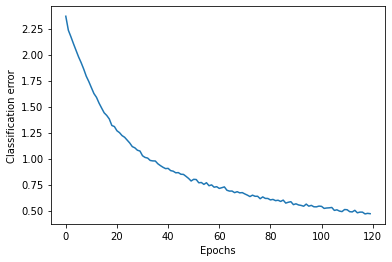

In [ ]:
# Plot Train Loss Encoder
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg_class)
plt.xlabel('Epochs')
plt.ylabel('Classification error')
plt.show()

In [ ]:
# NOT NEEDED

for image_batch, _ in dataloader:
  image_batch = image_batch.to(device)

  # autoencoder reconstruction
  image_batch_encode = autoencoder.encoder(image_batch)
  print(image_batch_encode.shape)
  break

torch.Size([128, 256])


In [ ]:

classify.eval()
classify_test_loss_avg = 0
num_batches = 0
for image_batch, target in dataloader_test:
    
    with torch.no_grad():

        image_batch = image_batch.to(device)
        target = target.to(device)
        # autoencoder reconstruction
        
        latent = autoencoder.encoder(image_batch)
        latent = latent.to(device)
        image_batch_classify = classify(latent)

        # reconstruction error
        loss = F.cross_entropy(image_batch_classify, target)

        classify_test_loss_avg += loss.item()
        num_batches += 1
    
classify_test_loss_avg /= num_batches
print('average Classification error: %f' % (classify_test_loss_avg))

average Classification error: 5.899841
